# Importing packages

In [1]:
import os
import io
import json
import math
import folium
import zipfile
import shapely
import sklearn
import openpyxl
import requests
import numpy as np 
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import geopandas as gpd
import branca.colormap as cm
from datetime import datetime
import matplotlib.pyplot as plt
from shapely.geometry import Point
from folium.plugins import HeatMap
from branca.colormap import linear
from pandas_ods_reader import read_ods
from folium.plugins import FastMarkerCluster
from shapely.geometry.polygon import Polygon
from folium.plugins import TimeSliderChoropleth
from sklearn.linear_model import LinearRegression
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'


import matplotlib.ticker as ticker
import matplotlib.animation as animation
from IPython.display import HTML
from sklearn.metrics import mean_squared_error
import base64
from folium import IFrame

# Import files

In [2]:
dirname='Data'

In [149]:
#Import file containing the information about, among others, postcodes, local authority
postcode_active = pd.read_csv(dirname+'/postcodes_active.csv',low_memory=False) 

In [150]:
postcode_active.columns

Index(['pcd', 'pcd2', 'pcds', 'dointr', 'doterm', 'usertype', 'oseast1m',
       'osnrth1m', 'osgrdind', 'oa11', 'cty', 'ced', 'laua', 'ward', 'hlthau',
       'nhser', 'ctry', 'rgn', 'pcon', 'eer', 'teclec', 'ttwa', 'pct', 'nuts',
       'park', 'lsoa11', 'msoa11', 'wz11', 'ccg', 'bua11', 'buasd11',
       'ru11ind', 'oac11', 'lat', 'long', 'lep1', 'lep2', 'pfa', 'imd',
       'calncv', 'stp', 'Postcode District', 'laua_name'],
      dtype='object')

In [158]:
postcode_active['rgn']= postcode_active['rgn'].replace({'N99999999':'N92000002','S99999999':'S92000003','W99999999':'W92000004'})

In [159]:
rgn_list = sorted([item for item in postcode_active['rgn'].unique()])

In [161]:
ctry_list = [item for item in postcode_active['ctry'].unique()]

In [162]:
la_list = [item for item in postcode_active['laua'].unique()]

In [163]:
dic_region = {item:postcode_active[postcode_active['rgn']==item]['laua'].unique().tolist() for item in rgn_list}

In [164]:
df_import = pd.read_excel('https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/959367/electric-vehicle-charging-device-statistics-january-2021.ods', sheet_name = 'EVCD_01a')
df_import = df_import[df_import.iloc[:,1].notnull()]
df_import = df_import.set_index('Department for Transport statistics')

In [165]:
dic_region_name = {item:df_import[df_import.index==item].iloc[0,0] for item in dic_region.keys()}

In [166]:
dic_la_name = {item:df_import[df_import.index==item].iloc[0,0] for item in la_list}

In [167]:
df_import = df_import.iloc[:,1:]

In [168]:
df_import

,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
Department for Transport statistics,,,,,,,,,,,,
LA / Region Code,2021-01-01 00:00:00,NaN,2020-10-01 00:00:00,NaN,2020-07-01 00:00:00,NaN,2020-04-01 00:00:00,NaN,2020-01-01 00:00:00,NaN,2019-10-01 00:00:00,NaN
K02000001,20775,31.101786,19487,29.17355,18265,27.33963,17947,27.014151,16505,24.843627,15116,22.752879
K03000001,20455,31.516195,19169,29.534781,17953,27.656597,17642,27.329096,16210,25.110795,14821,22.959105
E92000001,17459,31.017841,16456,29.235901,15395,27.345587,14979,26.75912,13719,24.508202,12549,22.418065
E12000001,820,30.712289,849,31.798455,812,30.412657,786,29.572119,752,28.292917,738,27.766188
...,...,...,...,...,...,...,...,...,...,...,...,...
N09000006,38,32.3688,38,32.3688,38,32.3688,38,32.5245,38,32.5245,38,32.5245
N09000007,11,7.534143,11,7.534143,11,7.534143,11,7.618731,11,7.618731,11,7.618731
N09000008,27,19.386246,27,19.386246,27,19.386246,25,18.015032,25,18.015032,24,18.735633


In [169]:
header =  [item.strftime("%B %Y") for item in df_import.iloc[0][::2]]

In [171]:
df = df_import.drop(columns = df_import.columns[::2])[1:]
df.columns = header
df.index.name = 'LA_code'
df = df.astype(float)

In [172]:
df_sorted = df.iloc[:,::-1].pct_change(axis = 'columns')*100

In [173]:
df.iloc[:,::-1]

,October 2019,January 2020,April 2020,July 2020,October 2020,January 2021
LA_code,,,,,,
K02000001,22.752879,24.843627,27.014151,27.339630,29.173550,31.101786
K03000001,22.959105,25.110795,27.329096,27.656597,29.534781,31.516195
E92000001,22.418065,24.508202,26.759120,27.345587,29.235901,31.017841
E12000001,27.766188,28.292917,29.572119,30.412657,31.798455,30.712289
E06000047,17.457968,18.217010,19.355573,19.807808,19.996453,20.751037
...,...,...,...,...,...,...
N09000006,32.524500,32.524500,32.524500,32.368800,32.368800,32.368800
N09000007,7.618731,7.618731,7.618731,7.534143,7.534143,7.534143
N09000008,18.735633,18.015032,18.015032,19.386246,19.386246,19.386246


In [176]:
df_sel = df[df.index.isin(la_list)]
print(len(df_sel))

379


# Stats

In [177]:
top10_uk_19 = df_sel.sort_values('October 2019',ascending=False).head(10)
top10_uk_19['La_name'] = [dic_la_name[item] for item in top10_uk_19.index]
top10_uk_19[['La_name','October 2019']]

,La_name,October 2019
LA_code,,
E09000001,City of London,413.507926
E09000033,Westminster,189.954724
E09000013,Hammersmith and Fulham,147.767843
E09000027,Richmond upon Thames,141.185552
E09000032,Wandsworth,126.809486
S12000023,Orkney Islands,108.156827
E09000020,Kensington and Chelsea,104.355397
S12000013,Na h-Eileanan Siar,100.633619
E06000042,Milton Keynes,96.051108


In [178]:
top10_uk_21 = df_sel.sort_values('January 2021',ascending=False).head(10)
top10_uk_21['La_name'] = [dic_la_name[item] for item in top10_uk_21.index]
top10_uk_21[['La_name','January 2021']]

,La_name,January 2021
LA_code,,
E09000001,City of London,360.045263
E09000020,Kensington and Chelsea,269.008320
E09000033,Westminster,247.209328
E09000013,Hammersmith and Fulham,208.487493
E09000032,Wandsworth,180.176354
E09000027,Richmond upon Thames,165.135669
S12000023,Orkney Islands,143.691064
E09000007,Camden,133.689345
E06000042,Milton Keynes,121.355170


In [180]:
top10_2019 = []
top10_2021 = []

for item in tqdm(sorted(rgn_list)):
    df_rgn = df_sel[df_sel.index.isin(dic_region[item])]
    
    top10_19 = df_rgn.sort_values('October 2019',ascending=False).head(10)
    top10_21 = df_rgn.sort_values('January 2021',ascending=False).head(10)
    
    top10_19['La_name'] = [dic_la_name[item] for item in top10_19.index]
    top10_2019.append(top10_19[['La_name','October 2019']])
    
    top10_21['La_name'] = [dic_la_name[item] for item in top10_21.index]
    top10_2021.append(top10_21[['La_name','January 2021']])

100%|██████████| 12/12 [00:00<00:00, 113.21it/s]


In [181]:
dic_region_name

{'E12000001': 'NORTH EAST',
 'E12000002': 'NORTH WEST',
 'E12000003': 'YORKSHIRE AND THE HUMBER',
 'E12000004': 'EAST MIDLANDS',
 'E12000005': 'WEST MIDLANDS',
 'E12000006': 'EAST OF ENGLAND',
 'E12000007': 'LONDON',
 'E12000008': 'SOUTH EAST',
 'E12000009': 'SOUTH WEST',
 'N92000002': 'NORTHERN IRELAND',
 'S92000003': 'SCOTLAND',
 'W92000004': 'WALES'}

In [182]:
index=6
print(dic_region_name[sorted(rgn_list)[index]])
print(top10_2019[index])
print(top10_2021[index])

LONDON
                          La_name  October 2019
LA_code                                        
E09000001          City of London    413.507926
E09000033             Westminster    189.954724
E09000013  Hammersmith and Fulham    147.767843
E09000027    Richmond upon Thames    141.185552
E09000032              Wandsworth    126.809486
E09000020  Kensington and Chelsea    104.355397
E09000018                Hounslow     83.831274
E09000019               Islington     76.523572
E09000007                  Camden     63.304173
E09000005                   Brent     62.576520
                          La_name  January 2021
LA_code                                        
E09000001          City of London    360.045263
E09000020  Kensington and Chelsea    269.008320
E09000033             Westminster    247.209328
E09000013  Hammersmith and Fulham    208.487493
E09000032              Wandsworth    180.176354
E09000027    Richmond upon Thames    165.135669
E09000007                  Camden

In [184]:
# top10_final = []
# for index in range(12):
#     rgn_name = pd.DataFrame([[dic_region_name[sorted(rgn_list)[index]],'','','']],columns=['La_name','October 2019','La_name','January 2021'])
#     top10_list = rgn_name.append(pd.concat([top10_2019[index],top10_2021[index]],axis=1),ignore_index = True)
#     if index == 0:
#         top10_final = top10_list
#     else:
#         top10_final = top10_final.append(top10_list)

In [185]:
top10_final = []
for index in range(12):
    rgn_name = pd.DataFrame([[dic_region_name[sorted(rgn_list)[index]],'']],columns=['La_name','January 2021'])
    top10_list = rgn_name.append(top10_2021[index],ignore_index = True)
    if index == 0:
        top10_final = top10_list
    else:
        top10_final = top10_final.append(top10_list)

In [186]:
top10_final[66:77]

,La_name,January 2021
0,LONDON,
1,City of London,360.045263
2,Kensington and Chelsea,269.00832
3,Westminster,247.209328
4,Hammersmith and Fulham,208.487493
5,Wandsworth,180.176354
6,Richmond upon Thames,165.135669
7,Camden,133.689345
8,Islington,97.332833
9,Hounslow,96.124454


In [37]:
top10_final.to_csv('Top10_byregion.csv')

# Rate of chargers growth by LA

In [188]:
# Assuming a linear relationship between number of chargers and time, determine the parameters of the line of best fit.

fit_coeff = []
for item in tqdm(df_sel.index):
    x = np.array([range(0,540,90)]).reshape((-1,1))
    y = df_sel.loc[item,::-1]
    model = LinearRegression()
    model = model.fit(x,y)
    
    y_actual = y
    y_predicted = [model.coef_[0]*item + model.intercept_ for item in x]
    rmse = round(mean_squared_error(y_actual, y_predicted, squared=False),2)
    
    fit_coeff.append([item,round(model.coef_[0],3),round(model.intercept_,2),round(model.score(x,y),2), rmse])
    

100%|██████████| 379/379 [00:01<00:00, 358.29it/s]


In [189]:
df_fit = pd.DataFrame(fit_coeff, columns= ['LA_code','Gradient','Intercept','R^2','RMSE'])
df_fit = df_fit.set_index('LA_code')
df_fit['Difference'] = round(df['January 2021']-df['October 2019'],2)

In [190]:
df_fit.head()

,Gradient,Intercept,R^2,RMSE,Difference
LA_code,,,,,
E06000047,0.007,17.67,0.95,0.24,3.29
E06000005,0.005,25.21,0.91,0.23,1.82
E06000001,0.006,5.06,0.77,0.51,3.18
E06000002,0.007,18.48,0.80,0.52,3.49
E06000057,0.011,43.52,0.54,1.64,2.81


Check if a relationship exist between the extracted gradient and the absolute difference between number pof chargers in October 2019 and January 2021

Gradient:  471.01
Intercept:  0.2
R^2:  0.95
RMSE:  15.43


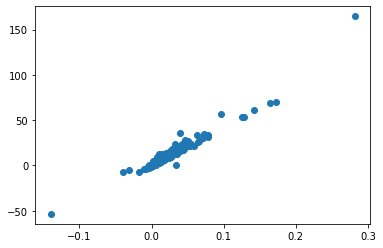

In [191]:
x = df_fit['Gradient'].values.reshape((-1,1))
y = df_fit['Difference'].values

y_actual = y
y_predicted = [model.coef_[0]*item + model.intercept_ for item in x]
rmse = round(mean_squared_error(y_actual, y_predicted, squared=False),2)

model = LinearRegression()
model = model.fit(x,y)


plt.scatter(x,y)
print('Gradient: ', round(model.coef_[0],2))
print('Intercept: ', round(model.intercept_,2))
print('R^2: ', round(model.score(x,y),2))
print('RMSE: ', rmse)

The data suggest that there exist a strong correlation between the absolute difference of chargers and the determined slope of the best fit line. Therefore, the absolute difference in chargers represents a good proxy for the ability of local authorities to respond to charging devices demand.

In [192]:
index= -1
rgn_code = sorted(rgn_list)[index]
rgn = dic_region_name[rgn_code]
print(rgn)

WALES


In [979]:
national_avg = round(df_fit['Difference'].mean(),2) 
print(national_avg)

8.47


In [196]:
top10_growth = []
for index in tqdm(range(12)):

    rgn_code = sorted(rgn_list)[index]
    rgn = dic_region_name[rgn_code]
    print(rgn)
    
    df_fit_sel = df_fit[df_fit.index.isin(dic_region[rgn_code])]
    df_fit_sel['LA_name'] = [dic_la_name[item] for item in df_fit_sel.index]
    df_fit_sel['National trend'] = ['Above' if item >= national_avg else 'Below' for item in df_fit_sel['Difference']]
    fit_final = df_fit_sel.sort_values('Difference',ascending=False)[['LA_name','Difference','National trend']].head(10)
    
    rgn_name = pd.DataFrame([[rgn,'','']],columns=['LA_name','Difference','National trend'])
    top10_list = rgn_name.append(fit_final,ignore_index = True)
    if index == 0:
        top10_growth = top10_list
    else:
        top10_growth = top10_growth.append(top10_list)

  0%|          | 0/12 [00:00<?, ?it/s]<ipython-input-196-c545f550d8d2>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fit_sel['LA_name'] = [dic_la_name[item] for item in df_fit_sel.index]
<ipython-input-196-c545f550d8d2>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fit_sel['National trend'] = ['Above' if item >= national_avg else 'Below' for item in df_fit_sel['Difference']]
100%|██████████| 12/12 [00:00<00:00, 76.74it/s]

NORTH EAST
NORTH WEST
YORKSHIRE AND THE HUMBER
EAST MIDLANDS
WEST MIDLANDS
EAST OF ENGLAND
LONDON
SOUTH EAST
SOUTH WEST
NORTHERN IRELAND
SCOTLAND
WALES


In [568]:
top10_growth.to_csv('Top10_byregion_growth.csv')

<AxesSubplot:>

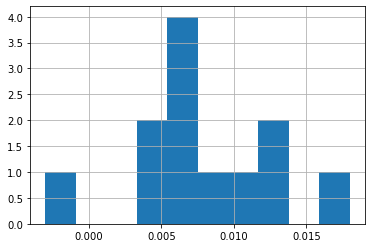

In [197]:
df_fit[df_fit.index.isin(dic_region[sorted(rgn_list)[0]])]['Gradient'].hist()

In [200]:
sum_tot = 0
for item in sorted(dic_region.keys()):
    print(item,dic_region_name[item],len(dic_region[item]))
    sum_tot += len(dic_region[item])
print('Total ',sum_tot)

E12000001 NORTH EAST 12
E12000002 NORTH WEST 39
E12000003 YORKSHIRE AND THE HUMBER 21
E12000004 EAST MIDLANDS 40
E12000005 WEST MIDLANDS 30
E12000006 EAST OF ENGLAND 45
E12000007 LONDON 33
E12000008 SOUTH EAST 64
E12000009 SOUTH WEST 30
N92000002 NORTHERN IRELAND 11
S92000003 SCOTLAND 32
W92000004 WALES 22
Total  379


In [201]:
df_fit.sort_values('Gradient',ascending= False)[:10]

,Gradient,Intercept,R^2,RMSE,Difference
LA_code,,,,,
E09000020,0.282,127.05,0.81,21.05,164.65
E09000007,0.172,50.91,0.79,13.63,70.39
E06000043,0.164,16.41,0.93,6.70,68.38
E09000013,0.142,142.76,0.92,6.34,60.72
E09000032,0.128,119.58,0.77,10.64,53.37
S12000010,0.126,42.08,0.88,7.09,53.59
E09000033,0.096,195.02,0.72,9.28,57.25
E07000136,0.078,4.77,0.79,6.24,34.10
E07000196,0.078,4.02,0.77,6.51,31.10


In [202]:
df_fit.describe()

,Gradient,Intercept,R^2,RMSE,Difference
count,379.000000,379.000000,379.000000,379.000000,379.000000
mean,0.017544,23.362216,0.709736,1.601979,8.467230
std,0.026661,29.825743,0.237158,2.068002,12.912981
min,-0.140000,-0.070000,0.000000,0.000000,-53.460000
25%,0.006000,9.860000,0.630000,0.555000,2.485000
50%,0.013000,17.240000,0.780000,1.030000,6.040000
75%,0.023000,25.430000,0.880000,1.835000,10.880000
max,0.282000,421.640000,1.000000,21.050000,164.650000


## Plots for the interactive map

In [83]:
resolution, width, height = 75, 7, 3

In [84]:
df_sel.iloc[0,::-1]

October 2019    17.457968
January 2020    18.217010
April 2020      19.355573
July 2020       19.807808
October 2020    19.996453
January 2021    20.751037
Name: E06000047, dtype: float64

In [85]:
subdirplot = dirname+'/LA_plots'

if os.path.basename(os.getcwd())== 'local_authority_charging':
    if not os.path.isdir(subdirplot):
        try:
            os.mkdir(subdirplot)
        except OSError:
            print ("Creation of the directory %s failed" % subdirplot)
        else:
            print ("Successfully created the directory %s " % subdirplot)
    else: 
        print ("Directory %s already exists" % subdirplot)

Directory Data/LA_plots already exists


In [206]:
for item in tqdm(df_sel.index):
    
    png = subdirplot+'/{}.png'.format(plot_sel.name)
    
    if os.path.isfile(file_path):
        pass
    else:
    
        plot_sel = df_sel.loc[item,::-1]
        plt.ion()
        fig, ax = plt.subplots(figsize=(width, height))
        plot_sel.plot(ax=ax, legend=False)
        ax.set_ylabel('Chargers per 100,000 pop (#)')
        ax.set_title(dic_la_name[plot_sel.name])
        plt.close(fig)
        fig.savefig(png, dpi=resolution, bbox_inches='tight')

100%|██████████| 379/379 [00:00<00:00, 18496.46it/s]


# Timeseries plot

In [207]:
subdirla = dirname+'/LA_borders'

if os.path.basename(os.getcwd())== 'local_authority_charging':
    if not os.path.isdir(subdirla):
        try:
            os.mkdir(subdirla)
        except OSError:
            print ("Creation of the directory %s failed" % subdirla)
        else:
            print ("Successfully created the directory %s " % subdirla)
    else: 
        print ("Directory %s already exists" % subdirla)

Directory Data/LA_borders already exists


In [208]:
filename = 'Local_Authority_Districts__May_2020__Boundaries_UK_BGC.geojson'
file_path = subdirla+'/'+filename
    
if os.path.isfile(file_path):
    print ("File %s already exists" % filename)
else:
    download_from_url('https://opendata.arcgis.com/datasets/3b374840ce1b4160b85b8146b610cd0c_0.geojson',file_path)
    print ("Successfully downloaded the file %s " % filename)

File Local_Authority_Districts__May_2020__Boundaries_UK_BGC.geojson already exists


In [209]:
la_geo = subdirla+'/Local_Authority_Districts__May_2020__Boundaries_UK_BGC.geojson'

In [210]:
gpdimport = gpd.read_file(la_geo)
gpdimport = gpdimport.set_index('LAD20CD')
gpdfinal = gpdimport.drop(['OBJECTID','LAD20NMW','BNG_E','BNG_N','LONG','LAT','Shape__Area','Shape__Length'], axis =1)

In [211]:
gpdfinal.head()

,LAD20NM,geometry
LAD20CD,,
E06000001,Hartlepool,"MULTIPOLYGON (((-1.23001 54.62512, -1.22990 54..."
E06000002,Middlesbrough,"MULTIPOLYGON (((-1.27714 54.54789, -1.27720 54..."
E06000003,Redcar and Cleveland,"MULTIPOLYGON (((-1.20098 54.57763, -1.20037 54..."
E06000004,Stockton-on-Tees,"MULTIPOLYGON (((-1.27694 54.54718, -1.27694 54..."
E06000005,Darlington,"POLYGON ((-1.63800 54.61720, -1.63767 54.61670..."


In [212]:
df_left = gpdfinal
df_right = df_sel.iloc[:,::-1]
df_concat = pd.concat([df_left,df_right], join='inner',axis=1).reset_index()
df_concat.head()

,index,LAD20NM,geometry,October 2019,January 2020,April 2020,July 2020,October 2020,January 2021
0,E06000001,Hartlepool,"MULTIPOLYGON (((-1.23001 54.62512, -1.22990 54...",5.362390,5.362390,6.434868,6.405945,6.405945,8.541260
1,E06000002,Middlesbrough,"MULTIPOLYGON (((-1.27714 54.54789, -1.27720 54...",17.787897,19.210929,20.633961,20.570294,20.570294,21.279614
2,E06000003,Redcar and Cleveland,"MULTIPOLYGON (((-1.20098 54.57763, -1.20037 54...",12.434354,12.434354,14.628652,14.582574,17.499089,17.499089
3,E06000004,Stockton-on-Tees,"MULTIPOLYGON (((-1.27694 54.54718, -1.27694 54...",36.001683,37.015815,38.537013,43.071123,43.577842,42.564404
4,E06000005,Darlington,"POLYGON ((-1.63800 54.61720, -1.63767 54.61670...",25.336411,25.336411,26.274797,26.216492,27.152795,27.152795


In [540]:
n_periods, n_sample = df_right.shape[1],df_right.shape[1]

datetime_index = pd.date_range('2019-10', periods=n_periods, freq='3M')
dt_index_epochs = datetime_index.astype(int) // 10**9
dt_index = dt_index_epochs.astype('U10')

In [541]:
styledata = {}

for area in df_right.index:
    df = pd.DataFrame(
        {'color': df_right.loc[area].values,
         'opacity': 0*np.random.normal(size=n_periods)},
        index=dt_index
    )
    #df = df.cumsum()
    #df.sample(n_sample, replace=False).sort_index()
    df.loc[:,'opacity'] = np.ones(n_periods)
    styledata[area] = df

In [542]:
max_color, min_color = 0, 100

for area, data in styledata.items():
    max_color = max(max_color, data['color'].max())
    min_color = min(min_color, data['color'].min())
        
cmap = linear.YlGnBu_09.scale(min_color, max_color)
#cmap = linear.YlGnBu_09.to_step(420).scale(0, 420)
#cmap = linear.YlGnBu_09.to_step(data=df_right['October 2019'], method='quant', quantiles=[0,0.1,0.75,0.9,0.98,1])

for area, data in styledata.items():
    data['color'] = data['color'].apply(cmap)
    data['opacity'] = (data['opacity'])
    data['opacity'] = (data['opacity'])

In [543]:
styledict = {
    str(area): data.to_dict(orient='index') for
    area, data in styledata.items()
}

## Approach 0: Original time slider

In [987]:
m = folium.Map([54.7, -4.6], tiles='cartodbpositron', zoom_start=5)

g = TimeSliderChoropleth(
    df_left.to_json(),
    styledict=styledict,
    control = False
).add_to(m)

myscale = (df_concat['October 2019'].quantile((0,0.1,0.75,0.9,0.98,1))).tolist()


choropleth = folium.Choropleth(
    geo_data=df_concat,
    data=df_concat,
    name = 'Local Authorities',
    columns=['index', 'October 2019'],
    key_on='feature.properties.index',
    fill_color= 'YlGnBu',
    fill_opacity=0.0,
    line_opacity=0.0,
    #threshold_scale=myscale,
    legend_name='Chargers per 100,000 pop',
    smooth_factor=0).add_to(m)





# style_function = lambda x: {'fillColor': '#ffffff', 
#                             'color':'#000000', 
#                             'fillOpacity': 0.0, 
#                             'weight': 0.0}


# highlight_function = lambda x: {'fillColor': '#000000', 
#                                 'color':'#000000', 
#                                 'fillOpacity': 0.50, 
#                                 'weight': 0.1}
# choropleth.geojson.add_child(
#     folium.features.GeoJson(
#     df_concat,
#     style_function=style_function, 
#     control=False,
#     highlight_function=highlight_function, 
#     tooltip=folium.features.GeoJsonTooltip(
#         fields=['index'],
#         aliases=['Local Authority:'],
#         style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
#     )
# ))



# for item in tqdm(df_concat['index']):
    
#     row_sel = df_concat[df_concat['index']==item]
    
#     lat= row_sel['geometry'].iloc[0].centroid.y
#     lon = row_sel['geometry'].iloc[0].centroid.x
    
#     var_name = row_sel['LAD20NM'].iloc[0]
#     var_loc = round(row_sel['January 2021'].iloc[0],2)
#     var_picture = base64.b64encode(open(subdirplot+'/'+item+'.png', 'rb').read()).decode()

#     html = f'''<img ALIGN="Right" src="data:image/png;base64,{var_picture}">\
#     <br />
#     <h3> Local Authority: </h3>{var_name}<br />\
#     <h3>Chargers per 100,000 population: </h3>{var_loc}<br />\
#     '''.format

#     iframe = IFrame(html(), width=(width*resolution)+180, height=(height*resolution)+20)
#     popup = folium.Popup(iframe, max_width=10000)
#     icon = folium.Icon(icon = 'map-marker',color=None)
#     marker = folium.Marker([lat, lon], popup=popup, icon=None)
#     marker.add_to(m)

for item in tqdm(df_concat['index']):
    
    row_sel = df_concat[df_concat['index']==item]
    
    lat= row_sel['geometry'].iloc[0].centroid.y
    lon = row_sel['geometry'].iloc[0].centroid.x
    
    var_name = row_sel['LAD20NM'].iloc[0]
    var_loc = round(row_sel['January 2021'].iloc[0],2)
    var_picture = base64.b64encode(open(subdirplot+'/'+item+'.png', 'rb').read()).decode()

    html = f'''<img ALIGN="Right" src="data:image/png;base64,{var_picture}">\
    <br />
    <h3> Local Authority: </h3>{var_name}<br />\
    <h3>Chargers per 100,000 population: </h3>{var_loc}<br />\
    '''.format

    iframe = IFrame(html(), width=(width*resolution)+180, height=(height*resolution)+20)
    popup = folium.Popup(iframe, max_width=10000)
    folium.CircleMarker(
        location=[lat,lon],
        popup=popup,
        color="#3186cc00",
        fill=True,
    ).add_to(m)

folium.LayerControl().add_to(m) 

#m

100%|██████████| 379/379 [00:01<00:00, 206.92it/s]


In [ ]:
m.save('Chargers_all_info.html')

## Approach 1: New time slider with popup for each time stamp 

In [765]:
time_frames = []
time_frames.append([datetime_index[0].strftime("%Y-%m-%dT%H:%M:%S")])
for i in range(1,len(datetime_index)):
        time_frames.append([datetime_index[i-1].strftime("%Y-%m-%dT%H:%M:%S"),datetime_index[i].strftime("%Y-%m-%dT%H:%M:%S")])

In [982]:
features  = []
idx = 0
for idx in range(len(time_frames)):
    for item in tqdm(df_concat['index']):

        #print(styledata[item]['color'][0])

        row_sel = df_concat[df_concat['index']==item]
        www = json.loads(row_sel.geometry.to_json())

        var_name = row_sel['LAD20NM'].iloc[0]
        var_loc = round(row_sel.iloc[0,idx+3],2)
        var_picture = base64.b64encode(open(subdirplot+'/'+item+'.png', 'rb').read()).decode()

        html = f'''<img ALIGN="Right" src="data:image/png;base64,{var_picture}", height = 100%, width = 100%>\
        <br />
        <h3> {var_name} </h3>
        <h4>Chargers per 100,000 population: </h4>  <h3>{var_loc}</h3>\
        '''

        features.append({
        'geometry': www['features'][0]['geometry'],
        'properties': {
            'style': {
                'color': styledata[item]['color'][idx],
                'weight': 0,
                'fillOpacity': styledata[item]['opacity'][idx]
            },
            'times': time_frames[idx]*len(www['features'][0]['geometry']['coordinates']),
            'popup': html
        },
        'type': 'Feature'
    })

100%|██████████| 379/379 [00:02<00:00, 156.85it/s]


In [962]:
# feat = [{
#     'geometry': {'type':www['features'][0]['geometry']['type'],
#                  'coordinates': www['features'][0]['geometry']['coordinates']
#                 },
#     'properties': {
#         'style': {
#             'color': 'black',
#             'weight': 0,
#             'fillOpacity': styledata[item]['opacity'][0]
#         },
#         'times': time_frames[idx]*6,
#         'popup': html
#     },
#     'type': 'Feature'
# }]

In [985]:
from folium.plugins import TimestampedGeoJson
m = folium.Map([54.7, -4.6], tiles='cartodbpositron', zoom_start=5)


choropleth = folium.Choropleth(
    geo_data=df_concat,
    data=df_concat,
    name = 'Local Authorities',
    columns=['index', 'October 2019'],
    key_on='feature.properties.index',
    fill_color= 'YlGnBu',
    fill_opacity=0.0,
    line_opacity=0.0,
    #threshold_scale=myscale,
    legend_name='Chargers per 100,000 pop',
    smooth_factor=0).add_to(m)

TimestampedGeoJson(
    {'type': 'FeatureCollection', 'features': features},
    period='P3M',
    duration=None,
    auto_play=False,
    loop=False,
    loop_button=True,
    date_options='MMMM YYYY',
).add_to(m)

#m

In [984]:
m.save('Charging_allinfo_newlayout.html')

## Approach 2: New time slider but single popup as a layer at end of the plot

In [950]:
htmls = [] 
for item in tqdm(df_concat['index']):

    #print(styledata[item]['color'][0])

    row_sel = df_concat[df_concat['index']==item]
    www = json.loads(row_sel.geometry.to_json())

    var_name = row_sel['LAD20NM'].iloc[0]
    var_loc = round(row_sel.iloc[0,idx+3],2)
    var_picture = base64.b64encode(open(subdirplot+'/'+item+'.png', 'rb').read()).decode()

    htmls.append(f'''
        <img src="data:image/png;base64,{var_picture}"/>
        <body>
        <h3> Local Authority: </h3> <h4>{var_name}</h4>
        <h3>Chargers per </br> 100,000 population: </h3>  <h4>{var_loc}</h4>
        </body>
        ''')

100%|██████████| 379/379 [00:02<00:00, 147.27it/s]


In [951]:
df_concat['fields'] = htmls

In [986]:
m = folium.Map([54.7, -4.6], tiles='cartodbpositron', zoom_start=5)

TimestampedGeoJson(
    {'type': 'FeatureCollection', 'features': features},
    period='P3M',
    duration=None,
    auto_play=False,
    loop=False,
    loop_button=False,
    date_options='MMMM YYYY',
).add_to(m)


style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.0, 
                            'weight': 0.0}

NIL = folium.features.GeoJson(df_concat, style_function = style_function ,tooltip = folium.features.GeoJsonTooltip(fields=['fields'],
                                                                                 aliases=[''],
                                                                                 style=("height: 410px; width: 500px; background-color: white;")))

m.add_child(NIL)
m.keep_in_front(NIL)
folium.LayerControl().add_to(m)

#m

In [969]:
m.save('Charging_allinfo_new.html')